In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import time

# Data

 - Two simulation cases are considered in the paper
 -- Due to privacy issues, we do not provide the original data in real applications. 
 -- However, we provide the simulated data.
 -- The simulated data are generated by manipulating the original data in real applications.
 - This is the __FIRST__ case.

## load data

In [2]:
# path for loading the simulated data
path = r'F:\xxx\simulated_data'
# path for saving results
path_save = r'F:\xxx\results'
# data for illustration
df = pd.read_excel(path+'\wheel1_simulated.xlsx')
# data of wheel #1-4 for training
df_wheel1 = pd.read_excel(path+'\wheel1_simulated.xlsx')
df_wheel2 = pd.read_excel(path+'\wheel2_simulated.xlsx')
df_wheel3 = pd.read_excel(path+'\wheel3_simulated.xlsx')
df_wheel4 = pd.read_excel(path+'\wheel4_simulated.xlsx')
# data of wheel #5 for test
df_wheel5 = pd.read_excel(path+'\wheel5_simulated.xlsx')

## show original data

In [3]:
df1 = df

print('number of observations on one wheel: ',df_wheel1.db.size)

number of observations on one wheel:  10711


In [4]:
df_wheel1.head()

,Unnamed: 0,mileage,db
0,0,20,12.513511
1,1,40,11.747744
2,2,60,17.114142
3,3,80,26.361180
4,4,100,37.117974


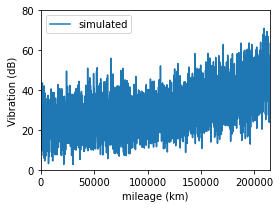

In [5]:
plt.rcParams["figure.figsize"] = (4,3)

plt.plot(df.mileage,df.db.rolling(4).mean(),label='simulated')

plt.xlabel('mileage (km)')
plt.ylabel('Vibration (dB)')
plt.ylim([0,80])
plt.xlim([0,215000])
plt.tight_layout()
plt.legend()

# Box-Cox transformation

- Technical details for Box-Cox transformation are provided in Section 3.1.1 in our paper

## illustration

- Given different values of $\alpha$, we calculate the 
-- $\lambda$ that maximizes the log-likelihood function; see the log-likelihood function is in Equation (4) in the paper
-- interval estimates for $\lambda$; see technical details in Equation (5) in the paper

In [6]:
for alpha in [0.0001,0.9]:
    signal_boxcox,max_lambda,ci_lambda = stats.boxcox(df1.db,alpha=alpha)
    print('================================================')
    print('alpha= ',alpha)
    print('lambda:',max_lambda)
    print('ci_lambda',ci_lambda)

alpha=  0.0001
lambda: 0.6906063430259698
ci_lambda (0.6476293455120566, 0.7343300820201404)
alpha=  0.9
lambda: 0.6906063430259698
ci_lambda (0.6892065862799533, 0.6920068429441286)


## application

### DEF: Box Cox transformation for our data

- find the ML estimate of $\lambda$ first, denoted as $\hat\lambda$

In [7]:
signal_boxcox,max_lambda,ci_lambda = stats.boxcox(df_wheel1.db.rolling(1).mean(),alpha=0.025)
print('=====================')
print('lambda ML estimate         :  ',max_lambda)
print('lambda confidence interval :  ',ci_lambda)

lambda ML estimate         :   0.6906063430259698
lambda confidence interval :   (0.6657561631849201, 0.7157043428165942)


- set different values of $\lambda$ around ML estimate $\hat{\lambda}$

In [8]:
def box_cox_on_data(df,lambdas):
    signal = df.db.rolling(4).mean()
    
    # first, calculate the best lambda
    signal_boxcox,max_lambda,ci_lambda = stats.boxcox(signal,alpha=0.025)
    print('================================================================================')
    print('lambda ML estimate         :',max_lambda)
    print('lambda confidence interval :',ci_lambda)

    # define the dataframe
    df_boxcox = pd.DataFrame({'mileage' : df.mileage})
    signals_names = []
    signals_var_names = []
    for lamb in lambdas:
        signal_boxcox = stats.boxcox(x = signal,lmbda = lamb)
        name = 'signal_boxcox_lamb'+str(lamb)
        signals_names.append(name)
        df_boxcox[name] = signal_boxcox
        name2 = 'signal_boxcox_var_lamb'+str(lamb)
        signals_var_names.append(name2)
        df_boxcox[name2] = df_boxcox[name].rolling(10).std()

    df_boxcox = df_boxcox.dropna() # drop the NaN
    df_boxcox = df_boxcox.reset_index()
    return df_boxcox,signals_names

### box_cox transformation on all wheels data

In [9]:
lambdas= [0.4,0.5,0.65,0.7,0.8,0.9,1]

df_wheel1_boxcox,signals_names = box_cox_on_data(df_wheel1,lambdas)
df_wheel2_boxcox,signals_names = box_cox_on_data(df_wheel2,lambdas)
df_wheel3_boxcox,signals_names = box_cox_on_data(df_wheel3,lambdas)
df_wheel4_boxcox,signals_names = box_cox_on_data(df_wheel4,lambdas)
df_wheel5_boxcox,signals_names = box_cox_on_data(df_wheel5,lambdas)

lambda ML estimate         : 8.472135811722177
lambda confidence interval : (1.9263406583655017e-12, 1.0200137480435589e-12)
lambda ML estimate         : 8.472135811722177
lambda confidence interval : (1.9263406583655017e-12, 1.0200137480435589e-12)
lambda ML estimate         : 8.472135811722177
lambda confidence interval : (1.9263406583655017e-12, 1.0200137480435589e-12)
lambda ML estimate         : 8.472135811722177
lambda confidence interval : (1.9263406583655017e-12, 1.0200137480435589e-12)
lambda ML estimate         : 8.472135811722177
lambda confidence interval : (1.9263406583655017e-12, 1.0200137480435589e-12)


### show the transformed data

lambda ML estimate         : 8.472135811722177
lambda confidence interval : (1.9263406583655017e-12, 1.0200137480435589e-12)


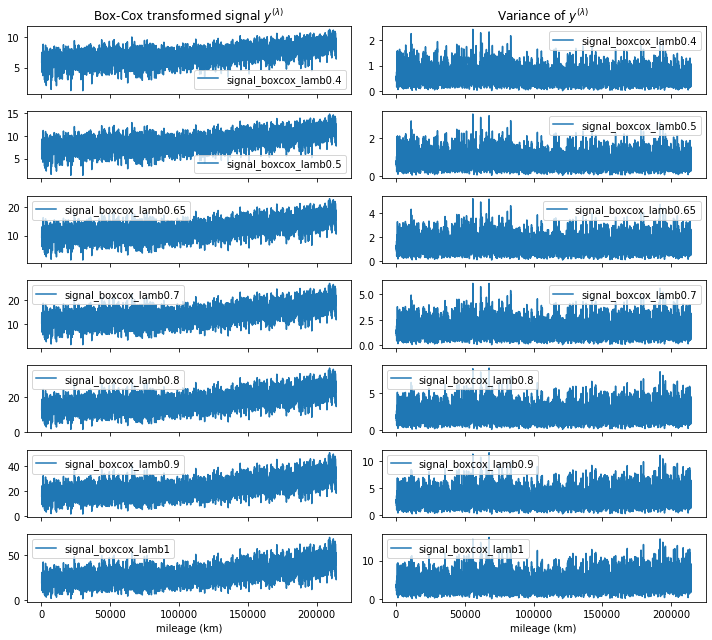

In [10]:
df_boxcox,signals_names = box_cox_on_data(df_wheel1,lambdas)

fig,axs = plt.subplots(7,2,sharex = True, figsize=(10,9))

i = 0
for key in signals_names:
    axs[i,0].plot(df_boxcox['mileage'],df_boxcox[key], label = key)
    axs[i,1].plot(df_boxcox['mileage'],df_boxcox[key].rolling(4).std(), label = key)
    # axs[i,1].hist(df_boxcox[key], bins = 25, density = True, edgecolor = 'black',alpha = 0.8, label = key)
    i = i+1
    
axs[6,0].set_xlabel('mileage (km)')
axs[6,1].set_xlabel('mileage (km)')
axs[0,0].set_title('Box-Cox transformed signal $y^{(\lambda)}$')
axs[0,1].set_title('Variance of $y^{(\lambda)}$')


for axs in fig.get_axes():
    axs.legend()
    axs.set_xticks(np.arange(0,230000,50000))

plt.tight_layout()

# plt.savefig(path_save+'\wheel1.png',dpi = 500)
# plt.savefig(path_save+'\wheel1.svg',dpi = 500)

- have a look at the transformed data

In [11]:
df_wheel1_boxcox.head()

,index,mileage,signal_boxcox_lamb0.4,signal_boxcox_var_lamb0.4,signal_boxcox_lamb0.5,signal_boxcox_var_lamb0.5,signal_boxcox_lamb0.65,signal_boxcox_var_lamb0.65,signal_boxcox_lamb0.7,signal_boxcox_var_lamb0.7,signal_boxcox_lamb0.8,signal_boxcox_var_lamb0.8,signal_boxcox_lamb0.9,signal_boxcox_var_lamb0.9,signal_boxcox_lamb1,signal_boxcox_var_lamb1
0,12,260,5.880844,0.908380,7.072243,1.239570,9.445949,1.977692,10.436232,2.311474,12.797710,3.158639,15.785124,4.318273,19.576400,5.906327
1,13,280,6.859310,0.887289,8.415013,1.210624,11.604868,1.931140,12.965501,2.256929,16.269339,3.083744,20.550519,4.215416,26.118122,5.765039
2,14,300,6.981647,0.917795,8.585459,1.252080,11.885177,1.996743,13.296369,2.333355,16.730325,3.187426,21.192796,4.355990,27.012986,5.955519
3,15,320,6.024479,0.896041,7.267014,1.223157,9.753501,1.952523,10.794370,2.282451,13.283350,3.120051,16.443660,4.266968,20.469387,5.838108
4,16,340,6.801266,0.827118,8.334336,1.126216,11.472668,1.790860,12.809644,2.090755,16.052710,2.850541,20.249423,3.888110,25.699624,5.305605


In [12]:
print('signals_names:\n',signals_names)

signals_names:
 ['signal_boxcox_lamb0.4', 'signal_boxcox_lamb0.5', 'signal_boxcox_lamb0.65', 'signal_boxcox_lamb0.7', 'signal_boxcox_lamb0.8', 'signal_boxcox_lamb0.9', 'signal_boxcox_lamb1']


# N-Beats for prediction

In [13]:
import torch
import tensorflow as tf
from tensorflow import keras
from keras import optimizers, layers

from numpy.random import seed

seed(1)

In [14]:
# pip install nbeats-keras

In [15]:
from nbeats_keras.model import NBeatsNet as NBeatsKeras
from nbeats_pytorch.model import NBeatsNet as NBeatsPytorch

## train the model

### check if the dataframe have the same length

In [16]:
print('======== some information about the original data ======')
dfs = [df_wheel1_boxcox,
       df_wheel2_boxcox,
       df_wheel3_boxcox,
       df_wheel4_boxcox]
for df in dfs:
    print('number of measurements on a wheel:',df.mileage.size)

======== some information about the original data ======
number of measurements on a wheel: 10699
number of measurements on a wheel: 10699
number of measurements on a wheel: 10699
number of measurements on a wheel: 10699


### TrainTestData

In [17]:
def TrainTestData(forecast_length,backcast_length,dfs,lamb,n,train_percent):
    forecast_length
    backcast_length

    # source domain data : lambda = 0.65 in simulation case #1
    lamb

    # generate the data into standard data shape
    x = []
    y = []
    t_x = []
    t_y = []
    for df in dfs:
        t = np.array(df.mileage)
        HI = np.array(df["signal_boxcox_lamb"+str(lamb)])
        for j in range(backcast_length,len(HI)-forecast_length,1):
            t_x.append(t[j-backcast_length:j].reshape(backcast_length,1))
            t_y.append(t[j:j+forecast_length].reshape(forecast_length,1))
            x.append(HI[j-backcast_length:j].reshape(backcast_length,1))
            y.append(HI[j:j+forecast_length].reshape(forecast_length,1))
        
    x = np.asarray(x) 
    y = np.asarray(y)
    t_x = np.asarray(t_x)
    t_y = np.asarray(t_y)
    
    # split data into training and testing datasets.
    # C is the number of total observations for four wheel
    # c is the numeber of observations of one wheel
    # w is the percent we want to use as training data
    print('total number of wheels in this dataset : ',n)
    C = x.shape[0]
    print('C - number of total observations for wheel : ',C)
    c = int(C/n)
    print('c - numeber of observations of one wheel: ',c)
    w = int(c*train_percent)
    print('w - the percent we want to use as training data: ',w)            
          
    # When seperating the data in dfs into training data and test data
    # we should consider two cases
    # （1）The first case is the number of wheels in our dfs dataset is larger than 1
    # this is usually the case when we want to train our model on the source domain
    # （2）The second case is the number of the wheels in our dfs dataset is equal to 1
    # this is usually the case when we want to fine-tune our model on the target domain
    
    # the training data from one wheel
    x_train = x[0:w]
    y_train = y[0:w]
    # the test data from one wheel
    x_test = x[w:c]
    y_test = y[w:c]
    # the mileages from training data
    t_x_train = t_x[0:w]
    t_y_train = t_y[0:w]
    # the mileages from the test data
    t_x_test = t_x[w:c]
    t_y_test = t_y[w:c]
    if n > 1:
        for i in range(1,n,1):
            # concatenate the training data from n wheels
            x_train = np.concatenate((x_train,x[i*c:i*c+w]))
            y_train = np.concatenate((y_train,y[i*c:i*c+w]))
            # concatenate the test data from n wheels
            x_test = np.concatenate((x_test,x[i*c+w:(i+1)*c]))
            y_test = np.concatenate((y_test,y[i*c+w:(i+1)*c]))
            # concatenate the mileages from training data of the n wheels
            t_x_train = np.concatenate((t_x_train,t_x[i*c:i*c+w]))
            t_y_train = np.concatenate((t_y_train,t_y[i*c:i*c+w]))
            # concatenate the mieages from the test data of the n wheels
            t_x_test = np.concatenate((t_x_test,t_x[i*c+w:(i+1)*c]))
            t_y_teat = np.concatenate((t_y_test,t_y[i*c+w:(i+1)*c]))

    test_size = len(x_test)
    
    # print('test_size = ',test_size)
    
    return x, y, t_x, t_y, x_train, y_train, x_test, y_test, t_x_train, t_y_train, t_x_test, t_y_test, t, HI

In [18]:
dfs[0].shape

(10699, 16)

In [19]:
dfs[0].size

171184

### train the model on training dataset

In [20]:
forecast_length = 20
backcast_length = 40
# we select the feature when lambda = 0.65 as the source domain feature
lamb = 1
n = 4
train_percent = 0.6
results = TrainTestData(forecast_length,
                        backcast_length,
                        dfs,
                        lamb,
                        n,
                        train_percent)

x = results[0] 
y = results[1]
t_x = results[2] 
t_y = results[3]
x_train = results[4] 
y_train = results[5] 
x_test = results[6]
y_test = results[7] 
t_x_train = results[8]
t_y_train = results[9] 
t_x_test = results[10] 
t_y_test = results[11] 
t = results[12] 
HI = results[13]

total number of wheels in this dataset :  4
C - number of total observations for wheel :  42556
c - numeber of observations of one wheel:  10639
w - the percent we want to use as training data:  6383


In [21]:
# NOTE: If you choose the Keras backend with input_dim>1, you have 
# to set the value here too (in the constructor).
output_dim = 1

test_size = len(x_test)

backend = NBeatsKeras(          
    backcast_length=backcast_length, 
    forecast_length=forecast_length,            
    stack_types=(NBeatsKeras.GENERIC_BLOCK, NBeatsKeras.GENERIC_BLOCK),            
    nb_blocks_per_stack=6, 
    thetas_dim=(4, 4), 
    share_weights_in_stack=True,
    hidden_layer_units=3
)

# Definition of the objective function and the optimizer.
backend.compile(loss='mae', 
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

# Train the model.
print('Training...')
backend.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=16)

# Save the model for later use
backend.save('n_beats_model_trained_on_lam'+str(lamb)+'.h5')
backend.save('n_beats_model.h5')

# Predict on the testing set (forecast).
predictions_forecast = backend.predict(x_test)

# Predict on the testing set (backcast).
predictions_backcast = backend.predict(x_test, return_backcast=True)

# Load the model.
model_2 = NBeatsKeras.load('n_beats_model_trained_on_lam'+str(lamb)+'.h5')


Training...
Epoch 1/20
1596/1596 [==============================] - 5s 2ms/step - loss: 6.8956 - val_loss: 5.5285
Epoch 2/20
1596/1596 [==============================] - 3s 2ms/step - loss: 5.5305 - val_loss: 5.8112
Epoch 3/20
1596/1596 [==============================] - 3s 2ms/step - loss: 5.4970 - val_loss: 5.6340
Epoch 4/20
1596/1596 [==============================] - 3s 2ms/step - loss: 5.4715 - val_loss: 5.3013
Epoch 5/20
1596/1596 [==============================] - 3s 2ms/step - loss: 5.4146 - val_loss: 5.9179
Epoch 6/20
1596/1596 [==============================] - 3s 2ms/step - loss: 5.3421 - val_loss: 5.5275
Epoch 7/20
1596/1596 [==============================] - 3s 2ms/step - loss: 5.3226 - val_loss: 6.4040
Epoch 8/20
1596/1596 [==============================] - 3s 2ms/step - loss: 5.3146 - val_loss: 6.6851
Epoch 9/20
1596/1596 [==============================] - 3s 2ms/step - loss: 5.3066 - val_loss: 6.2799
Epoch 10/20
1596/1596 [==============================] - 3s 2ms/step -

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [22]:
# have a look at the structure of our model
backend.summary()

Model: "forecast"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_variable (InputLayer)    [(None, 40, 1)]      0           []                               
                                                                                                  
 lambda (Lambda)                (None, 40)           0           ['input_variable[0][0]']         
                                                                                                  
 0/0/generic/d1 (Dense)         (None, 3)            123         ['lambda[0][0]',                 
                                                                  'subtract[0][0]',               
                                                                  'subtract_1[0][0]',             
                                                                  'subtract_2[0][0]',      

### perfomance of the trained model on test data

In [23]:
test_size = np.int(t.size/n)

C:\Users\yanbi\AppData\Local\Temp/ipykernel_100492/3350379849.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_size = np.int(t.size/n)


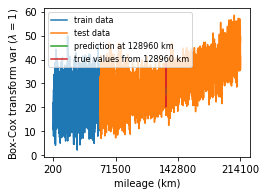

In [24]:
# this is the index, where the data before it is used for training, and the data after it is used for testing

plt.figure(figsize=(3.8,2.8))

plt.plot(t[0:test_size],HI[0:test_size],label='train data')
plt.plot(t[test_size:],HI[test_size:],label='test data')

for i in [12]:
    plt.plot(t_y_test[i],predictions_forecast[i],label='prediction at '+str(int(t_y_test[i][0][0]))+' km')
    plt.plot(t_y_test[i],y_test[i],label='true values from '+str(int(t_y_test[i][0][0]))+' km')

plt.xlabel('mileage (km)')
plt.ylabel('Box-Cox transform var ($\lambda$ = '+str(lamb)+')')

plt.xticks(np.arange(int(np.min(df_boxcox.mileage)/100)*100, np.max(df_boxcox.mileage), int((np.max(df_boxcox.mileage)-np.min(df_boxcox.mileage))/300)*100))

plt.tight_layout()

plt.legend(fontsize=8)
# plt.savefig(path_save+'\BC_'+str(lamb)+'_pred_at'+str(int(t_y_test[i][0]))+'.png',dpi=500)
# plt.savefig(path_save+'\BC_'+str(lamb)+'_pred_at'+str(int(t_y_test[i][0]))+'.svg',dpi=500)

number of the observations for test data 17024


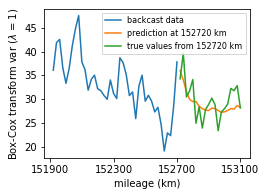

In [25]:
print('number of the observations for test data',len(x_test))

plt.figure(figsize=(3.8,2.8))

for i in [1200]:
    plt.plot(t_x_test[i],x_test[i],label='backcast data')
    plt.plot(t_y_test[i],predictions_forecast[i],label='prediction at '+str(int(t_y_test[i][0][0]))+' km')
    plt.plot(t_y_test[i],y_test[i],label='true values from '+str(int(t_y_test[i][0][0]))+' km')

    
plt.xticks(np.arange(int(np.min(t_x_test[i])/100)*100, np.max(t_y_test[i]+100), int((np.max(t_y_test[i])-np.min(t_x_test[i]))/250)*100))

    
plt.xlabel('mileage (km)')
plt.ylabel('Box-Cox transform var ($\lambda$ = '+str(lamb)+')')

plt.tight_layout()

plt.legend(fontsize=8)
# plt.savefig(path_save+'\BC_'+str(lamb)+'_prediction_at'+str(int(t_y_test[i][0]))+'_zoomin.png',dpi=500)
# plt.savefig(path_save+'\BC_'+str(lamb)+'_prediction_at'+str(int(t_y_test[i][0]))+'_zoomin.svg',dpi=500)

## predict feature on wheel5

### load the trained model on dataset {wheel1-4}
-  lambda=1

In [26]:
lamb = 1
model_trained = NBeatsKeras.load('n_beats_model_trained_on_lam'+str(lamb)+'.h5')

### define the data of wheel5

In [27]:
forecast_length = 20
backcast_length = 40
# we select the feature when lambda = 0.65 as the source domain feature
lamb = 1
n = 1
train_percent = 0.3
results = TrainTestData(forecast_length,
                        backcast_length,
                        [df_wheel5_boxcox],
                        lamb,
                        n,
                        train_percent)

x_transfer = results[0] 
y_transfer = results[1]
t_x_transfer = results[2] 
t_y_transfer = results[3]
x_train_transfer = results[4] 
y_train_transfer = results[5] 
x_test_transfer = results[6]
y_test_transfer = results[7] 
t_x_train_transfer = results[8]
t_y_train_transfer = results[9] 
t_x_test_transfer = results[10] 
t_y_test_transfer = results[11] 
t_transfer = results[12] 
HI_transfer = results[13]

total number of wheels in this dataset :  1
C - number of total observations for wheel :  10639
c - numeber of observations of one wheel:  10639
w - the percent we want to use as training data:  3191


### fine tuning the trained model 
- with some data on wheel5

In [28]:
model_trained.trainable = False
model_trained.layers[-6].trainable = True
model_trained.layers[-3].trainable = True
print(model_trained.trainable)
print(model_trained.layers[-6].trainable)

False
True


In [29]:
# Train the model.
print('Re-Training...')
    
history = model_trained.fit(x_train_transfer, 
                  y_train_transfer, 
                  validation_data=(x_test_transfer, y_test_transfer), 
                  epochs=10, 
                  batch_size=16)

# Save the model for later.
model_trained.save('n_beats_model_transfer.h5')

# Predict on the testing set (forecast).
predictions_forecast_transfer = model_trained.predict(x_test_transfer)

Re-Training...
Epoch 1/10
200/200 [==============================] - 2s 4ms/step - loss: 5.6319 - val_loss: 6.3111
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 5.6200 - val_loss: 6.5197
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 5.6192 - val_loss: 6.5863
Epoch 4/10
200/200 [==============================] - 1s 3ms/step - loss: 5.6157 - val_loss: 6.4684
Epoch 5/10
200/200 [==============================] - 1s 3ms/step - loss: 5.6148 - val_loss: 6.4230
Epoch 6/10
200/200 [==============================] - 1s 3ms/step - loss: 5.6135 - val_loss: 6.7026
Epoch 7/10
200/200 [==============================] - 1s 3ms/step - loss: 5.6107 - val_loss: 6.6040
Epoch 8/10
200/200 [==============================] - 1s 3ms/step - loss: 5.6095 - val_loss: 6.9146
Epoch 9/10
200/200 [==============================] - 1s 3ms/step - loss: 5.6062 - val_loss: 6.4155
Epoch 10/10
200/200 [==============================] - 1s 3ms/step - loss: 5.6082 - v

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


### prediction result plot

t_transfer.size: 10699
idx5:  3200
prediction mileage: 64260


C:\Users\yanbi\AppData\Local\Temp/ipykernel_100492/1562569444.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx5 = forecast_length*np.int(t_transfer.size*train_percent/forecast_length)


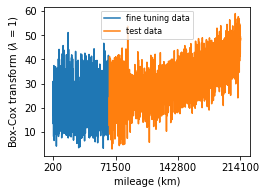

In [30]:
plt.figure(figsize=(3.8,2.8))

idx5 = forecast_length*np.int(t_transfer.size*train_percent/forecast_length)

print('t_transfer.size:',t_transfer.size)
print('idx5: ',idx5)
print('prediction mileage:',t_transfer[idx5])

plt.plot(t_transfer[0:idx5],HI_transfer[0:idx5],label='fine tuning data')
plt.plot(t_transfer[idx5:],HI_transfer[idx5:],label='test data')
 
plt.xlabel('mileage (km)')
plt.ylabel('Box-Cox transform ($\lambda$ = '+str(lamb)+')')

plt.xticks(np.arange(int(np.min(df_boxcox.mileage)/100)*100, np.max(df_boxcox.mileage), int((np.max(df_boxcox.mileage)-np.min(df_boxcox.mileage))/300)*100))

plt.tight_layout()

plt.legend(fontsize=8)
# plt.savefig(path_save+'\BC_'+str(lamb)+'_prediction_at'+str(int(t_transfer[idx5]))+'.png',dpi=500)
# plt.savefig(path_save+'\BC_'+str(lamb)+'_prediction_at'+str(int(t_transfer[idx5]))+'.svg',dpi=500)

- np.concatenate the test data

In [31]:
x_test_transfer = x_test_transfer.reshape((-1,1))
t_x_test_transfer = t_x_test_transfer.reshape((-1,1))
t_y_test_transfer = t_y_test_transfer.reshape((-1,1))
predictions_forecast_transfer = predictions_forecast_transfer.reshape((-1,1))
y_test_transfer = y_test_transfer.reshape((-1,1))

print(t_x_test_transfer.shape)
print(x_test_transfer.shape)

(297920, 1)
(297920, 1)


297920


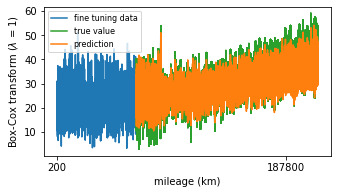

In [32]:
print(len(x_test_transfer))

plt.figure(figsize=(4.8,2.8))

plt.plot(t_transfer,HI_transfer,label='fine tuning data')
plt.plot(t_y_test_transfer,y_test_transfer,label='true value',color='tab:green')
plt.plot(t_y_test_transfer,predictions_forecast_transfer,label='prediction',color='tab:orange')

plt.xticks(np.arange(int(np.min(t_transfer)/100)*100, np.max(t_transfer+100), int((np.max(t_y_test_transfer)-np.min(t_x_test_transfer))/80)*100))

plt.xlabel('mileage (km)')
plt.ylabel('Box-Cox transform ($\lambda$ = '+str(lamb)+')')

plt.tight_layout()

plt.legend(fontsize=8)
# plt.savefig(path_save+'\BC_'+str(lamb)+'_prediction_at'+str(int(t_y_test_transfer[i][0]))+'_zoomin.png',dpi=500)
# plt.savefig(path_save+'\BC_'+str(lamb)+'_prediction_at'+str(int(t_y_test_transfer[i][0]))+'_zoomin.svg',dpi=500)

# fault time prediction

## fault alarm on predictions

### Function: alarm

In [33]:
def alarm(signal_lamb,threshold):
    diff = signal_lamb-threshold
    alarm_num = []
    for j in range(0,len(diff),1):
        diff_uptoj = diff[0:j]
        cum_num = diff_uptoj[diff_uptoj>0]
        alarm_num.append(len(cum_num))
        
    print('==================================================================')
    print('length of alarm_num:',len(alarm_num))

    return alarm_num

### Function: find the first index

In [34]:
def first_index(df,value):
    indices = df.index
    index_bool = df["mileage"] > value
    index = indices[index_bool]
    index = index[0]
    
    return index

### calculate the true cumulative number: true results

In [35]:
threshold = 42
# find the "index" where we conduct prediction
# we also need to use data after the "index" to compute the cumulative number
index = first_index(df_wheel5,t_y_test_transfer[0][0])
df_wheel5_boxcox_lamb1,signals_names = box_cox_on_data(df_wheel5[index:],[1])
signal_lamb_true = df_wheel5_boxcox_lamb1['signal_boxcox_lamb1']
signal_lamb_true = signal_lamb_true.rolling(30).mean()
alarm_num_true = alarm(signal_lamb_true,threshold)

lambda ML estimate         : 8.472135811722177
lambda confidence interval : (1.9263406583655017e-12, 1.0200137480435589e-12)
length of alarm_num: 7455


- plot the data we use to compute the true cumultive alarm number 

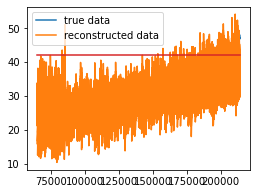

In [38]:
signal_lamb = predictions_forecast_transfer
plt.plot(df_wheel5_boxcox_lamb1.mileage,signal_lamb_true,label='true data')
plt.plot(t_y_test_transfer,signal_lamb,label='reconstructed data')
plt.plot([min(t_y_test_transfer),max(t_y_test_transfer)],[threshold,threshold],'tab:red')
plt.legend()

### calculate the cumulative based on mean: prediction results

In [39]:
alarm_num_mean = alarm(signal_lamb,threshold)

length of alarm_num: 148960


### plot result

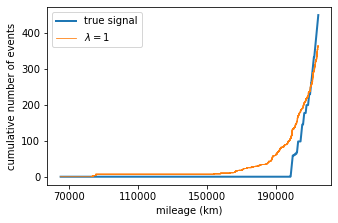

In [40]:
plt.figure(figsize=(4.8,3.2))

# plt.plot(df_wheel5_boxcox.mileage,alarm_num_true,label='true signal')

plt.plot(df_wheel5_boxcox_lamb1.mileage,alarm_num_true,label='true signal',linewidth=2)
plt.plot(t_y_test_transfer,alarm_num_mean ,label='$\lambda = $'+str(1),linewidth=0.8)
 
plt.xticks(np.arange(70000,230000,40000))

# plt.xlim([150000,220000])
# plt.ylim([-1,10])

plt.xlabel('mileage (km)')
plt.ylabel('cumulative number of events')

plt.legend()
plt.tight_layout()

# plt.savefig(path_save+'alarm_num.png',dpi=500)
# plt.savefig(path_save+'alarm_num.svg',dpi=500)

- compute the MAE of predictions

In [42]:
print('===================================================')
print('make prediction at: ', t_y_test_transfer[0][0])
print('===================================================')
failure_count = 6
# failure time of the true data
alarm_num_true = pd.Series(alarm_num_true)
failure_index_true = alarm_num_true[alarm_num_true>failure_count].index[0]
failure_time_true = df_wheel5_boxcox_lamb1.mileage[failure_index_true]
rul_true = failure_time_true-df_wheel5_boxcox_lamb1.mileage[0]
print('failure_time_true: ',failure_time_true)
print('rul_true: ',rul_true)
# failure time by predictions
alarm_num_mean = pd.Series(alarm_num_mean)
failure_index_mean = alarm_num_mean[alarm_num_mean>1].index[0]
failure_time_mean = t_y_test_transfer[failure_index_mean][0]
rul_mean = failure_time_mean-t_y_test_transfer[0][0]
print('failure_time_mean: ',failure_time_mean)
print('rul_mean: ',rul_mean)

MAE = np.abs(rul_mean-rul_true)/rul_true
print('===================================================')
print('The results in Table.7 in the paper')
print('Benchmark 1 MAE: ',MAE)
print('===================================================')

make prediction at:  64880
failure_time_true:  198340
rul_true:  133200
failure_time_mean:  83360
rul_mean:  18480
The results in Table.7 in the paper
Benchmark 1 MAE:  0.8612612612612612


# END